<a href="https://colab.research.google.com/github/xychong/edgeaimonitoring/blob/main/MobileNet_V2_Training_%5BUnfreeze_Layers_%2B_QAT%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow.compat.v2 as tf
import keras
from keras.models import Sequential
from keras.applications import mobilenet_v2

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)

2.6.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_data = np.load("/content/drive/MyDrive/FYP Data/Train and Test/train_data.npy", allow_pickle = True)
test_data = np.load("/content/drive/MyDrive/FYP Data/Train and Test/test_data.npy", allow_pickle = True)
train_label = np.load("/content/drive/MyDrive/FYP Data/Train and Test/train_label.npy", allow_pickle = True)
test_label = np.load("/content/drive/MyDrive/FYP Data/Train and Test/test_label.npy", allow_pickle = True)

In [5]:
print(train_data.shape)
print(test_data.shape)
print(train_label.shape)
print(test_label.shape)

(1204, 224, 224, 3)
(304, 224, 224, 3)
(1204, 1)
(304, 1)


In [6]:
from keras.applications.mobilenet_v2 import MobileNetV2
from keras import optimizers
from keras.models import Model
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dropout, Dense
from keras.layers import Activation, BatchNormalization, Add, Reshape, DepthwiseConv2D

In [7]:
# Create base model from pre-trained model MobileNetV2
base_model = MobileNetV2(input_shape=(224,224,3), include_top=False)

# Unfreeze the base model
base_model.trainable = True

# Observe how many layers are in the base model
# 154
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 152

# Freeze all layers before 'fine_tune_at' layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

for layer in base_model.layers:
  print(layer, layer.trainable)

# Base model architecture
# base_model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Number of layers in the base model:  154
<keras.engine.input_layer.InputLayer object at 0x7fd1ade5a810> False
<keras.layers.convolutional.Conv2D object at 0x7fd202e32fd0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fd1ad946350> False
<keras.layers.advanced_activations.ReLU object at 0x7fd1ad929910> False
<keras.layers.convolutional.DepthwiseConv2D object at 0x7fd1aa7bda50> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fd1aa769790> False
<keras.layers.advanced_activations.ReLU object at 0x7fd1aa789590> False
<keras.layers.convolutional.Conv2D object at 0x7fd1aa78d3d0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fd1aa799dd0> False
<keras.layers.convolutional.Conv2D object at 0x7fd1aa79a390> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fd1aa724150> False
<keras.lay

In [8]:
base_model.output

<KerasTensor: shape=(None, 7, 7, 1280) dtype=float32 (created by layer 'out_relu')>

In [9]:
## Adding additional layers

# Applies average pooling on spatial dimensions
# shape (None, 1280)
x = GlobalAveragePooling2D()(base_model.output) 

# Reshape (None, 1280) to (1, 1, 1280)
x = Reshape((1, 1, 1280))(x)

# Apply a Dropout
# Randomly selected neurons are ignored during training; helps prevent overfitting
# Dropout doesn't have any variables/weights that can be frozen during training
x = Dropout(0.3, name='Dropout')(x) 

# 2D convolutional layer
# Shape (1,1,5)
x = Conv2D(5, (1, 1), padding='same', data_format = 'channels_last')(x)

# Feeds all outputs from previous layers to all neurons
x = Activation('softmax', name='softmax')(x)  

# Reshape (1,1,5) to (,5)
# 5 represents the 5 sound classes
x = Reshape((5,))(x)

model = Model(inputs = base_model.inputs, outputs = x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [10]:
model.output_shape

(None, 5)

In [11]:
# Configuring the model
# Use crossentropy loss function when there are two or more label classes
# Labels are provided as integers -> Use sparse_categorical_crossentropy
# Adjust learning rate to reduce loss
#model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

opt = tf.keras.optimizers.Adam(learning_rate=0.0003)
model.compile(optimizer = opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [12]:
# Train the model
initial_epochs = 20
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs
training = model.fit(train_data, train_label, epochs=total_epochs, validation_data=(test_data, test_label), verbose=1)

Epoch 1/30
38/38 [==============================] - 45s 1s/step - loss: 1.2805 - accuracy: 0.4975 - val_loss: 1.3407 - val_accuracy: 0.4441
Epoch 2/30
38/38 [==============================] - 42s 1s/step - loss: 0.7738 - accuracy: 0.7425 - val_loss: 1.0828 - val_accuracy: 0.6349
Epoch 3/30
38/38 [==============================] - 41s 1s/step - loss: 0.5903 - accuracy: 0.8081 - val_loss: 0.9644 - val_accuracy: 0.6645
Epoch 4/30
38/38 [==============================] - 43s 1s/step - loss: 0.5035 - accuracy: 0.8389 - val_loss: 0.8972 - val_accuracy: 0.6645
Epoch 5/30
38/38 [==============================] - 42s 1s/step - loss: 0.4469 - accuracy: 0.8522 - val_loss: 0.8372 - val_accuracy: 0.6941
Epoch 6/30
38/38 [==============================] - 43s 1s/step - loss: 0.3919 - accuracy: 0.8679 - val_loss: 0.8352 - val_accuracy: 0.6809
Epoch 7/30
38/38 [==============================] - 43s 1s/step - loss: 0.3427 - accuracy: 0.9003 - val_loss: 0.7776 - val_accuracy: 0.7072
Epoch 8/30
38/38 [==

### Perform quantization aware training

#### Define the model
Resulting model is quantization aware but not quantized (weights are float32 instead of int8)

https://github.com/tensorflow/model-optimization/issues/368

https://colab.research.google.com/github/tensorflow/model-optimization/blob/master/tensorflow_model_optimization/g3doc/guide/quantization/training_example.ipynb#scrollTo=_PHDGJryE31X 

In [22]:
!pip uninstall tensorflow_model_optimization

Found existing installation: tensorflow-model-optimization 0.7.0
Uninstalling tensorflow-model-optimization-0.7.0:
  Would remove:
    /root/.local/lib/python3.7/site-packages/tensorflow_model_optimization-0.7.0.dist-info/*
    /root/.local/lib/python3.7/site-packages/tensorflow_model_optimization/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-model-optimization-0.7.0


In [23]:
! pip install -q tensorflow
! pip install -q tensorflow-model-optimization
#! pip install --user --upgrade tensorflow-model-optimization

In [24]:
import tensorflow_model_optimization as tfmot

In [25]:
import tensorflow.compat.v2 as tf
import tempfile

In [26]:
quantize_model = tfmot.quantization.keras.quantize_model

In [27]:
# q_aware stands for quantization aware
q_aware_model = quantize_model(model)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [28]:
# 'quantize_model' requires recompile
opt = tf.keras.optimizers.Adam(learning_rate=0.0003)
q_aware_model.compile(optimizer = opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [29]:
# All layers prefixed by "quant"
q_aware_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
quantize_layer (QuantizeLayer)  (None, 224, 224, 3)  3           input_1[0][0]                    
__________________________________________________________________________________________________
quant_Conv1 (QuantizeWrapperV2) (None, 112, 112, 32) 929         quantize_layer[1][0]             
__________________________________________________________________________________________________
quant_bn_Conv1 (QuantizeWrapper (None, 112, 112, 32) 129         quant_Conv1[0][0]                
______________________________________________________________________________________________

In [30]:
initial_epochs = 20
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs
q_training = q_aware_model.fit(train_data, train_label, epochs=60, validation_data=(test_data, test_label), verbose=1)

Epoch 1/60
38/38 [==============================] - 251s 6s/step - loss: 0.6460 - accuracy: 0.7591 - val_loss: 2.2205 - val_accuracy: 0.3947
Epoch 2/60
38/38 [==============================] - 234s 6s/step - loss: 0.3705 - accuracy: 0.8771 - val_loss: 1.6642 - val_accuracy: 0.5592
Epoch 3/60
38/38 [==============================] - 239s 6s/step - loss: 0.2360 - accuracy: 0.9161 - val_loss: 6.4417 - val_accuracy: 0.2138
Epoch 4/60
38/38 [==============================] - 239s 6s/step - loss: 0.1788 - accuracy: 0.9369 - val_loss: 8.6502 - val_accuracy: 0.2270
Epoch 5/60
38/38 [==============================] - 239s 6s/step - loss: 0.1719 - accuracy: 0.9394 - val_loss: 5.5577 - val_accuracy: 0.2138
Epoch 6/60
38/38 [==============================] - 240s 6s/step - loss: 0.0992 - accuracy: 0.9635 - val_loss: 5.0895 - val_accuracy: 0.2632
Epoch 7/60
38/38 [==============================] - 238s 6s/step - loss: 0.1798 - accuracy: 0.9377 - val_loss: 3.5102 - val_accuracy: 0.3980
Epoch 8/60
38

In [31]:
_, baseline_model_accuracy = model.evaluate(test_data, test_label, verbose=1)

_, q_aware_model_accuracy = q_aware_model.evaluate(test_data, test_label, verbose=1)

10/10 [==============================] - 12s 1s/step - loss: 9.9062 - accuracy: 0.3553


In [ ]:
print('Baseline test accuracy:', baseline_model_accuracy)
print('Quant test accuracy:', q_aware_model_accuracy)

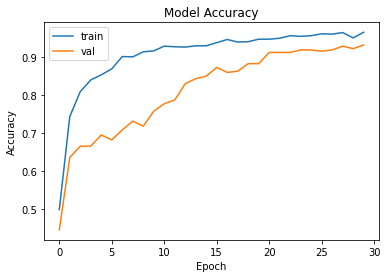

In [33]:
# Original Model
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

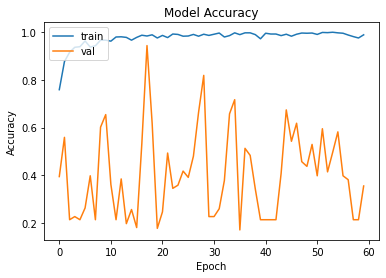

In [34]:
# Model after Quantization Aware Training
plt.plot(q_training.history['accuracy'])
plt.plot(q_training.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

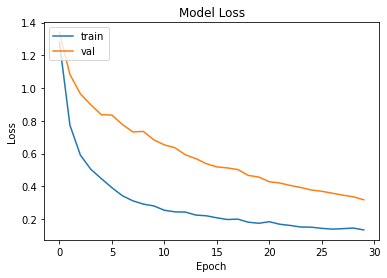

In [35]:
# Original Model
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

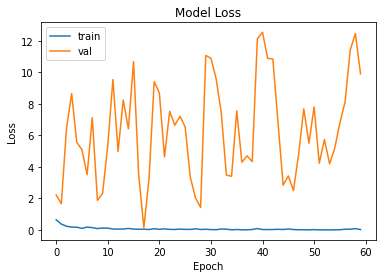

In [36]:
# Model after Quantization Aware Training
plt.plot(q_training.history['loss'])
plt.plot(q_training.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()